In [130]:
import msprime
import sys
import numpy as np
import seaborn as sns
from IPython.display import SVG
import matplotlib.pyplot as plt
from itertools import chain
from sklearn import preprocessing
from scipy.spatial import distance

In [302]:
#Reference Population
pop_configs = [
    msprime.PopulationConfiguration(sample_size=100)]
Ne = 100
recomb = 0.1
ts_ref = msprime.simulate(
    population_configurations=pop_configs,Ne = Ne,mutation_rate=0.25,recombination_rate = recomb,random_seed=11)
print(ts_ref.num_mutations)
print(ts_ref.segregating_sites())

500
500.0


In [349]:
#ABC Function
def ABC_regression(data,eps,pop_configs,Ne,recomb,prior="exponential",prior_parameters=1,iters=1000):
    ref_stat = (data.diversity(),data.segregating_sites())
    samples = []
    discrepancies = []
    if prior == "exponential":
        for i in range(0,iters):
            mutation_rate_sim = np.random.exponential(prior_parameters)
            ts_sim = msprime.simulate(population_configurations=pop_configs,Ne=Ne,recombination_rate=recomb,mutation_rate=mutation_rate_sim)
            sim_stat = (ts_sim.diversity(),ts_sim.segregating_sites())
            samples.append(mutation_rate_sim)
            discrepancy = np.subtract(sim_stat,ref_stat)
            discrepancies.append(discrepancy)
    elif prior == "uniform":
        for i in range(0,iters):
            mutation_rate_sim = np.random.uniform(prior_parameters[0],prior_parameters[1])
            ts_sim = msprime.simulate(population_configurations=pop_configs,Ne=Ne,recombination_rate=recomb,mutation_rate=mutation_rate_sim)
            sim_stat = (ts_sim.diversity(),ts_sim.Tajimas_D(),ts_sim.segregating_sites())
            if np.linalg.norm(np.subtract(ref_stat,sim_stat)) < eps:
                samples.append(mutation_rate_sim)
    elif prior == "gamma":
        for i in range(0,iters):
            mutation_rate_sim = np.random.gamma(prior_parameters[0],prior_parameters[1])
            ts_sim = msprime.simulate(population_configurations=pop_configs,Ne=Ne,recombination_rate=recomb,mutation_rate=mutation_rate_sim)
            sim_stat = (ts_sim.diversity(),ts_sim.Tajimas_D(),ts_sim.segregating_sites())
            if np.linalg.norm(np.subtract(sim_stat,ref_stat)) < eps:
                samples.append(mutation_rate_sim)
    cov_matrix = np.cov(np.array(discrepancies).T)
    reduced_sample_indices = []
    discrepancies = np.array(discrepancies)
    #discrepancies = preprocessing.scale(discrepancies)+np.mean(discrepancies)
    #print(np.mean(discrepancies),np.var(discrepancies))
    for j in range(len(ref_stat)):
        #discrepancies.T[j] = preprocessing.scale(discrepancies.T[j]) + np.mean(discrepancies.T[j])
        print(np.mean(discrepancies.T[j]),np.var(discrepancies.T[j]))
    for i in range(len(samples)):
        if np.linalg.norm(discrepancies[i]) < eps:
            reduced_sample_indices.append(i)
    return(samples,discrepancies,reduced_sample_indices)

In [422]:
%%time
#Exponential prior scale 0.2
iterations = 2000
eps = 500
prior= "exponential"
prior_parameters = 0.2
attempt1 = ABC_regression(ts_ref,eps=eps,pop_configs=pop_configs,Ne=Ne,recomb=recomb,prior=prior,prior_parameters=prior_parameters,iters=iterations)
samples = attempt1[0]
discrepancies = attempt1[1]
reduced_sample_indices = attempt1[2]
reduced_samples = np.array(samples)[np.ix_(reduced_sample_indices)]
reduced_discrepancies = np.array(discrepancies)[np.ix_(reduced_sample_indices)]
n = len(reduced_samples)
p = len(discrepancies[0])
print("Acceptance probability: ",n/iterations)

3.852339696969667 7094.261873758335
-78.733 185427.627711
Acceptance probability:  0.885
Wall time: 7.91 s


In [439]:
X = np.zeros((n,p+1))
W = np.zeros((n,n))
for i in range(n):
    for j in range(p+1):
        if j == 0:
            X[i][j]=1
        else:
            X[i][j]= reduced_discrepancies[i][j-1]
            #X[i][i] = reduced_discrepancies[i]
    norm = np.linalg.norm(reduced_discrepancies[i])
    K_eps = 3*(1-(norm/eps)**2)/(2*eps)
    W[i][i] = K_eps
    #W[i][i] = 1
XTWXinv = np.linalg.inv(np.dot(np.dot(X.T,W),X))
AB = np.dot(np.dot(np.dot(XTWXinv,X.T),W),reduced_samples)
print(AB)
Beta_hat = AB[1:]
adjusted_samples = np.subtract(reduced_samples,np.dot(reduced_discrepancies,Beta_hat))
alpha_hat = sum(np.dot(W,adjusted_samples))/W.sum()
print(alpha_hat)


[ 0.25965269 -0.00084811  0.00064497]
0.2596526893091106


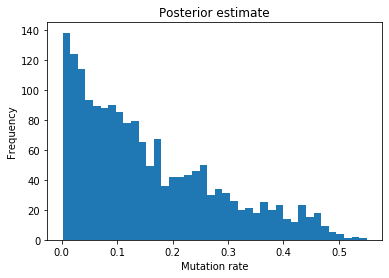

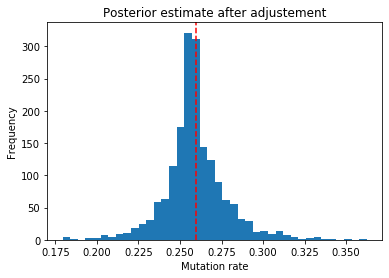

Point estimate :  0.2596526893091106


In [440]:
plt.hist(reduced_samples, bins = 40)
plt.ylabel('Frequency')
plt.xlabel('Mutation rate')
plt.title('Posterior estimate')
plt.show()
plt.hist(adjusted_samples, bins = 40)
plt.ylabel('Frequency')
plt.xlabel('Mutation rate')
plt.title('Posterior estimate after adjustement')
plt.axvline(x=alpha_hat,color="r",linestyle="dashed")
plt.show()
print("Point estimate : ",alpha_hat)

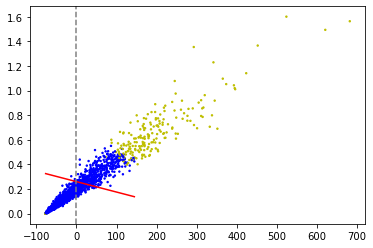

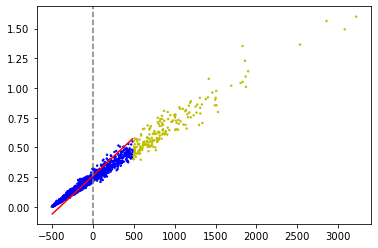

In [441]:
col = ["y"]*len(samples)
for i in reduced_sample_indices:
    col[i] = "b"
for i in range(p):
    data = discrepancies.T[i]
    lineStart = min(reduced_discrepancies.T[i])
    lineEnd = max(reduced_discrepancies.T[i])
    plt.scatter(data,samples,s=2,color = col)
    x = np.linspace(lineStart, lineEnd, 1000)
    plt.plot(x,Beta_hat[i]*x + AB[0],color="r")
    plt.axvline(x=0,color="gray",linestyle="dashed")
    plt.show()